In [1]:
import warnings

import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import sklearn.metrics as met
from openpyxl import load_workbook
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from random import randrange

from data_preprocessing import read_table, merge_str


In [2]:
np.random.seed(0)
random_state = 0

# Binary Prediction of Gentrified Tracts in Melbourne

This notebook was created to test the performance of the baseline model (Logistic Regression) and other off-the-shelf ML models that run with CPU. The training labels were obtained following Freeman's 5-step definition of gentrified areas.

The evaluation process is centered around Recall. In order to do wo while preventing the models from predicting all instances as positive, the main metric is F2 with recall being twice as aimportant as precision.

# Table of Contents

1. [Model Selection](#model_selection) 


&emsp; 1.1. [Models for 2006-2016 Gentrification Period](#2006_2016_model)

&emsp; 1.2. [Models for 2011-2016 Gentrification Period](#2011_2016_model)
   

# Model Selection <a name="model_selection"></a>

In [3]:
def print_metrics(model, y_test, X_test, name='model'):
    f2 = met.fbeta_score(y_test, model.predict(X_test), beta=2)
    print('F2: {}'.format(round(f2,3)))
    recall = met.recall_score(y_test, model.predict(X_test))
    print('Recall: {}'.format(round(recall,3)))
    precision = met.precision_score(y_test, model.predict(X_test))
    print('Precision: {}'.format(round(precision,3)))
    acc = met.accuracy_score(y_test, model.predict(X_test))
    print('Accuracy: {}'.format(round(acc,3)))

In [5]:
def plot_PRC(y_test, y_prob, name='model'):
    precision, recall, thresholds = met.precision_recall_curve(y_test, y_prob)
    pr_auc = met.auc(recall, precision)
    print('The PR-AUC: ' + str(round(pr_auc,3)))
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==True]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label=name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim(0,1)
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

##  2006-2016 Gentrification Period <a name='2006_2016_model'></a>

In [7]:
reduced_06_16 = pd.read_csv('Data/dataset_reduced_06_16.csv')
complete_06_16 = pd.read_csv('Data/dataset_complete_06_16.csv')

In [8]:
# Normalize dataset
scaler_R = preprocessing.MinMaxScaler()
X_06R = reduced_06_16.drop(columns = ['Unnamed: 0','SA1_MAINCO','Gentrified_06_16'], axis=1)
X_06R[X_06R.columns] = scaler_R.fit_transform(X_06R)
                                               
scaler_C = preprocessing.MinMaxScaler()
X_06C = complete_06_16.drop(columns = ['Unnamed: 0','SA1_MAINCO','Gentrified_06_16'], axis=1)
X_06C[X_06C.columns] = scaler_C.fit_transform(X_06C)



In order to determine a ratio  test-train split ratio that can guarantee stability in training, we look at the performance of the defined baseline model (Logistic Regression). The baseline model is trained with a changing test size from 1% to 50%. The threshold for a correct train-test split is taken from the point where the metric of choice (F2) starts to be contained within 1.5 times the standard deviation. 

In [11]:
f2 = []
seeds = [264,635,56,731,251]

for i in range(1,50):
    
    f2_seeds = []
    for seed in seeds:
        # data split
        X_06R_train, X_06R_test, y_06R_train, y_06R_test = train_test_split(X_06R,
                                                                        reduced_06_16['Gentrified_06_16'], 
                                                                        test_size=i/100,
                                                                           random_state=seed)
        # training of the baseline model
        LR_06R = LogisticRegression(class_weight='balanced',
                               penalty = 'l1',
                               solver='liblinear',
                               random_state = random_state)
        LR_06R.fit(X_06R_train, y_06R_train)

        # evaluation of the baseline model
        f2_seeds.append(met.fbeta_score(y_06R_test, LR_06R.predict(X_06R_test), beta=2))
    f2.append(statistics.mean(f2_seeds))
    


The variance is: 5.9691595083915563e-05


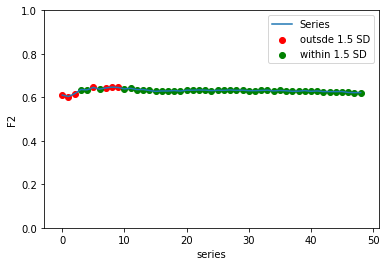

In [24]:
# Analysis of individual error compared to the standard deviation
std = statistics.stdev(f2)
mean = statistics.mean(f2)
accept = [[],[]]
inaccept = [[],[]]


for i in range(len(f2)):
    if abs(mean - f2[i]) > 1.5*std:
        inaccept[0].append(i)
        inaccept[1].append(f2[i])
    elif abs(mean - f2[i]) <= 1.5*std:
        accept[0].append(i)
        accept[1].append(f2[i])
        
# Plot results used to calculate the grand mean of metrics
plt.plot(f2, label='Series')
plt.scatter(inaccept[0], inaccept[1], c='red', label='outsde 1.5 SD')
plt.scatter(accept[0], accept[1], c='green', label='within 1.5 SD')
plt.xlabel('series')
plt.ylabel('F2')
plt.ylim(0,1)
plt.legend(loc=1)
plt.show
print('The variance is: ' + str(np.var(f2)))

We observe that the begining of a stable performance for the baseline model begings with a data split of 10%

In [9]:
# Split dataset
X_06R_train, X_06R_test, y_06R_train, y_06R_test = train_test_split(X_06R,
                                                                    reduced_06_16['Gentrified_06_16'], 
                                                                    test_size=0.10,
                                                                    random_state=0)

X_06C_train, X_06C_test, y_06C_train, y_06C_test = train_test_split(X_06C,
                                                                    complete_06_16['Gentrified_06_16'], 
                                                                    test_size=0.111,
                                                                    random_state=0)

Logistic Regression with Reduced number of demographic Features

F2: 0.636
Recall: 0.83
Precision: 0.329
Accuracy: 0.756
The PR-AUC: 0.352


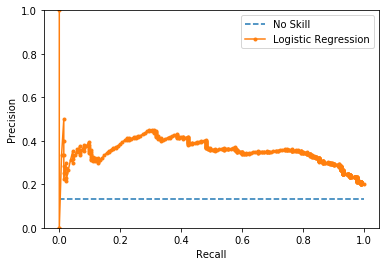

In [10]:
LR_06R = LogisticRegression(class_weight='balanced',
                           penalty = 'l1',
                           solver='liblinear',
                           random_state = random_state)
LR_06R.fit(X_06R_train, y_06R_train)

print_metrics(LR_06R, y_06R_test, X_06R_test, name='Logistic Regression')
plot_PRC(y_06R_test,
         LR_06R.predict_proba(X_06R_test)[:, 1],
         name='Logistic Regression')

Logistic Regression with all demographic Features

F2: 0.667
Recall: 0.823
Precision: 0.379
Accuracy: 0.804
The PR-AUC: 0.515


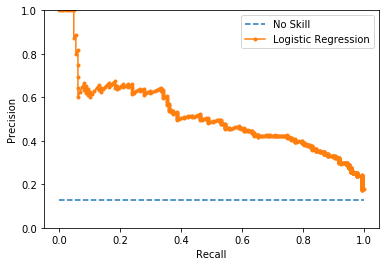

In [25]:
LR_06C = LogisticRegression(class_weight='balanced',
                           penalty = 'l1',
                           solver='liblinear')

LR_06C.fit(X_06C_train, y_06C_train)

print_metrics(LR_06C, y_06C_test, X_06C_test, name='Logistic Regression')

plot_PRC(y_06C_test,
         LR_06C.predict_proba(X_06C_test)[:, 1],
         'Logistic Regression')

Random Forest with a reduced number of demographic features:

F2: 0.464
Recall: 0.415
Precision: 0.875
Accuracy: 0.915
The PR-AUC: 0.82


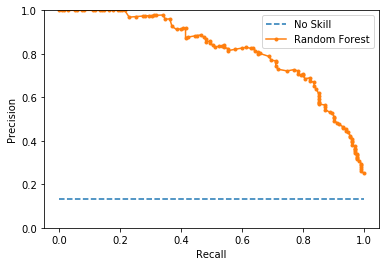

In [26]:
RF_06R = RandomForestClassifier(n_estimators=200,
                                criterion='gini',
                                max_features=0.6,
                                class_weight='balanced_subsample',
                                random_state=random_state
                                )
RF_06R.fit(X_06R_train, y_06R_train)

print_metrics(RF_06R, y_06R_test, X_06R_test, name='Random Forest')

plot_PRC(y_06R_test,
         RF_06R.predict_proba(X_06R_test)[:, 1],
         'Random Forest')

Random Forest with all of demographic Features

F2: 0.571
Recall: 0.524
Precision: 0.895
Accuracy: 0.931
The PR-AUC: 0.839


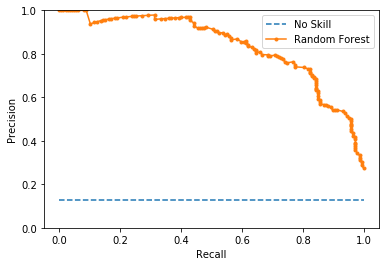

In [27]:
RF_06C = RandomForestClassifier(n_estimators=200,
                                criterion='gini',
                                max_features=0.6,
                                class_weight='balanced_subsample',
                                random_state=random_state
                                )
RF_06C.fit(X_06C_train, y_06C_train)

print_metrics(RF_06C, y_06C_test, X_06C_test, name='Random Forest')

plot_PRC(y_06C_test,
         RF_06C.predict_proba(X_06C_test)[:, 1],
         'Random Forest')

SVM with a reduced number of demographic features

In [28]:
SVM_06_R = SVC(kernel='linear',
              class_weight= 'balanced')
SVM_06_R.fit(X_06R_train, y_06R_train)
print_metrics(SVM_06_R, y_06R_test, X_06R_test, name='SVM')

F2: 0.643
Recall: 0.859
Precision: 0.32
Accuracy: 0.742


SVM with all of demographic features

In [29]:
SVM_06_C = SVC(kernel='linear',
              class_weight= 'balanced')
SVM_06_C.fit(X_06C_train, y_06C_train)
print_metrics(SVM_06_C, y_06C_test, X_06C_test, name='SVM')

F2: 0.651
Recall: 0.816
Precision: 0.359
Accuracy: 0.789


Naive bayes with a reduced number of demographic features

F2: 0.523
Recall: 0.844
Precision: 0.208
Accuracy: 0.557
The PR-AUC: 0.299


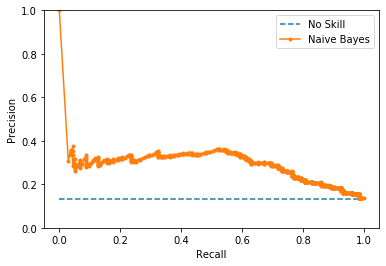

In [30]:
NB_06_R = GaussianNB()
NB_06_R.fit(X_06R_train, y_06R_train)

print_metrics(NB_06_R, y_06R_test, X_06R_test, name='Naive Bayes')

plot_PRC(y_06R_test,
         NB_06_R.predict_proba(X_06R_test)[:, 1],
         'Naive Bayes')

Naive Bayes with all of demographic features

F2: 0.517
Recall: 0.912
Precision: 0.189
Accuracy: 0.486
The PR-AUC: 0.543


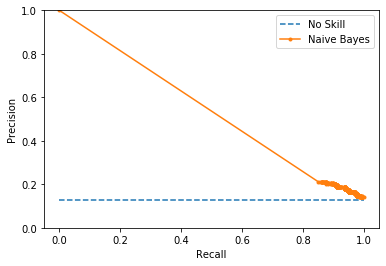

In [31]:
NB_06_C = GaussianNB()
NB_06_C.fit(X_06C_train, y_06C_train)

print_metrics(NB_06_C, y_06C_test, X_06C_test, name='Naive Bayes')

plot_PRC(y_06C_test,
         NB_06_C.predict_proba(X_06C_test)[:, 1],
         'Naive Bayes')

In the context of gentrification between 2006 and 2016 the baseline (Logistic Regresion) is the second best performing model, only after the SVM with a marignial improvement of 0.01. Both models perform better with the dataser reduced in demographic features. 

##  20011-2016 Gentrification Period <a name='2011_2016_model'></a>

In [32]:
reduced_11_16 = pd.read_csv('Data/dataset_reduced_11_16.csv')
complete_11_16 = pd.read_csv('Data/dataset_complete_11_16.csv')

In [33]:
# Normalize dataset
scaler_R = preprocessing.MinMaxScaler()
X_11R = reduced_11_16.drop(columns = ['Unnamed: 0','SA1_MAINCO','Gentrified_11_16'], axis=1)
X_11R[X_11R.columns] = scaler_R.fit_transform(X_11R)
                                               
scaler_C = preprocessing.MinMaxScaler()
X_11C = complete_11_16.drop(columns = ['Unnamed: 0','SA1_MAINCO','Gentrified_11_16'], axis=1)
X_11C[X_11C.columns] = scaler_C.fit_transform(X_11C)

# Split dataset
X_11R_train, X_11R_test, y_11R_train, y_11R_test = train_test_split(X_11R,
                                                                    reduced_11_16['Gentrified_11_16'], 
                                                                    test_size=0.10)

X_11C_train, X_11C_test, y_11C_train, y_11C_test = train_test_split(X_11C,
                                                                    complete_11_16['Gentrified_11_16'], 
                                                                    test_size=0.111)

Logistic Regression with a reduced number of demographic features

F2: 0.611
Recall: 0.848
Precision: 0.288
Accuracy: 0.755
The PR-AUC: 0.33


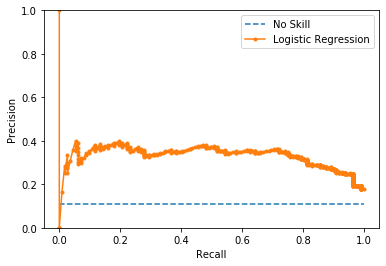

In [34]:
LR_11R = LogisticRegression(class_weight='balanced',
                           penalty = 'l1',
                           solver='liblinear',
                           random_state = random_state)
LR_11R.fit(X_11R_train, y_11R_train)

print_metrics(LR_11R, y_11R_test, X_11R_test, name='Logistic Regression')
plot_PRC(y_11R_test,
         LR_11R.predict_proba(X_11R_test)[:, 1],
         name='Logistic Regression')

Logistic Regression with all demographic features

F2: 0.554
Recall: 0.776
Precision: 0.259
Accuracy: 0.752
The PR-AUC: 0.293


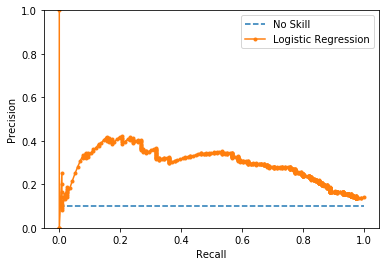

In [35]:
LR_11C = LogisticRegression(class_weight='balanced',
                           penalty = 'l1',
                           solver='liblinear')

LR_11C.fit(X_11C_train, y_11C_train)

print_metrics(LR_11C, y_11C_test, X_11C_test, name='Logistic Regression')

plot_PRC(y_11C_test,
         LR_11C.predict_proba(X_11C_test)[:, 1],
         'Logistic Regression')

Random Forest with a reduced number of demographic features

F2: 0.199
Recall: 0.17
Precision: 0.655
Accuracy: 0.9
The PR-AUC: 0.52


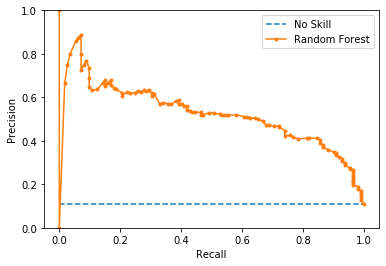

In [36]:
RF_11R = RandomForestClassifier(n_estimators=200,
                                criterion='gini',
                                max_features=0.6,
                                class_weight='balanced_subsample',
                                random_state=random_state
                                )
RF_11R.fit(X_11R_train, y_11R_train)

print_metrics(RF_11R, y_11R_test, X_11R_test, name='Random Forest')

plot_PRC(y_11R_test,
         RF_11R.predict_proba(X_11R_test)[:, 1],
         'Random Forest')

Random Forest with all demographic features

F2: 0.202
Recall: 0.172
Precision: 0.625
Accuracy: 0.906
The PR-AUC: 0.496


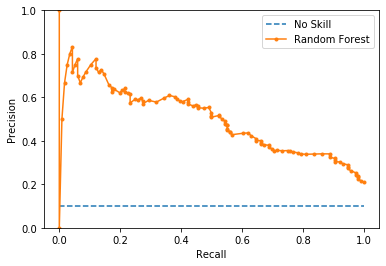

In [37]:
RF_11C = RandomForestClassifier(n_estimators=200,
                                criterion='gini',
                                max_features=0.6,
                                class_weight='balanced_subsample',
                                random_state=random_state
                                )
RF_11C.fit(X_11C_train, y_11C_train)

print_metrics(RF_11C, y_11C_test, X_11C_test, name='Random Forest')

plot_PRC(y_11C_test,
         RF_11C.predict_proba(X_11C_test)[:, 1],
         'Random Forest')

SVM with a reduced number of demographic features

In [38]:
SVM_11_R = SVC(kernel='linear',
              class_weight= 'balanced')
SVM_11_R.fit(X_11R_train, y_11R_train)
print_metrics(SVM_11_R, y_11R_test, X_11R_test, name='SVM')

F2: 0.593
Recall: 0.866
Precision: 0.262
Accuracy: 0.72


SVM with all the demographic features

In [39]:
SVM_11_C = SVC(kernel='linear',
              class_weight= 'balanced')
SVM_11_C.fit(X_11C_train, y_11C_train)
print_metrics(SVM_11_C, y_11C_test, X_11C_test, name='SVM')

F2: 0.561
Recall: 0.802
Precision: 0.255
Accuracy: 0.742


Naive Bayes with a reduced number of demographic features

F2: 0.43
Recall: 0.955
Precision: 0.134
Accuracy: 0.326
The PR-AUC: 0.535


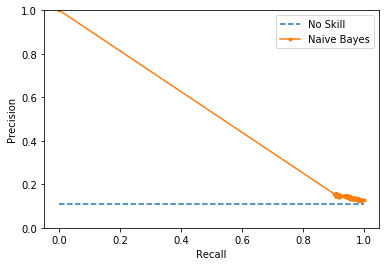

In [40]:
NB_11_R = GaussianNB()
NB_11_R.fit(X_11R_train, y_11R_train)

print_metrics(NB_11_R, y_11R_test, X_11R_test, name='Naive Bayes')

plot_PRC(y_11R_test,
         NB_11_R.predict_proba(X_11R_test)[:, 1],
         'Naive Bayes')

Naive Bayes with all the demographic features

F2: 0.397
Recall: 0.974
Precision: 0.118
Accuracy: 0.257
The PR-AUC: 0.548


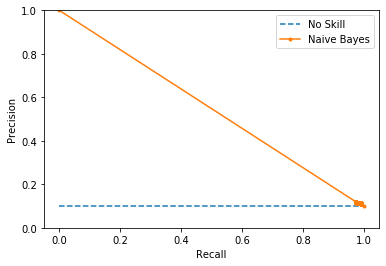

In [41]:
NB_11_C = GaussianNB()
NB_11_C.fit(X_11C_train, y_11C_train)

print_metrics(NB_11_C, y_11C_test, X_11C_test, name='Naive Bayes')

plot_PRC(y_11C_test,
         NB_11_C.predict_proba(X_11C_test)[:, 1],
         'Naive Bayes')

Overall, the models trained with data from a 5-year period of gentrification (2011-2016) have a lower performacne than thoe trained with the 10-year gentrification period. But both groups of models perform best -generally speaking- with a reduced number of demographic features. SVM and Logistic Regression are the best performing models in this experiement as well.